# Genetic Algorithm Lab

This notebook is meant to guide you in your first full program for the Artificial Intelligence course. Instructions and convenience classes are prepared for you, but you will need to fill in various code cells in order for the notebook to be fully-functioning. These code cells are marked with #TODO comments. Feel free to modify any other code in this notebook as well. In particular, wherever you see #SUGGESTION comments, you may want to explore alternatives (not compulsory).

The problem to be solved in this lab is the Travelling Salesman Problem. More details on this problem are provided in your lab sheet.

## Imports

In [1]:
%matplotlib inline
# Put the imports you need here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import csv
import operator
from pprint import pprint as print # pretty printing, easier to read but takes more room

## Convenience Classes

The 'City' class allows us to easily measure distance between cities. A list of cities is called a route, and will be our chromosome for this genetic algorithm.

In [2]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        #SUGGESTION - What if we wanted to use a different distance
        # metric? Would that make sense for this problem?
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

The 'Fitness' class helps to calculate both the distance and the fitness of a route (list of City instances).

In [3]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = None
        self.fitness = None
    
    def routeDistance(self):
        if self.distance == None:
            pathDistance = 0.0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i+1 < len(self.route):
                    toCity = self.route[i+1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == None:
            self.fitness = 1 / float(self.routeDistance())
            #SUGGESTION - Is the scaling an issue with this method
            # of defining fitness? Would negative distance make more
            # sense (obviously with properly defined selection functions)
        return self.fitness

## Initialization Step

Initialization starts with a large **population** of randomly generated chromosomes. We will use 3 functions. The first one generates a list of cities from a file.

In [4]:
def genCityList(filename):
    cityList = []
    
    data = pd.read_csv(filename, sep=" ", header=None)
    data.columns = ["index", "x_coordinate", "y_coordinate"]
    del data['index'] 
    
    
    for index, row in data.iterrows():
        
        cityList.append(City(row['x_coordinate'], row['y_coordinate']))
    
    return cityList

The second function generates a random route (chromosome) from a list of City instances.

In [5]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    
    return route

The third function repeatedly calls the second function to create an initial population (list of routes).

In [6]:
def initialPopulation(popSize, cityList):
    population = []
    
    for i in range(0, popSize):
       population.append(createRoute(cityList)) 
                
    #SUGGESTION - Could population be 'seeded' with known good routes?
    # In other words, would heuristic initialization help?
    return population

In [7]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
        
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

The cells below are set to have Markdown type, even though they contain python code. You should change their type and run them to test the functions you've created in this section. You can always change any cell's type to Markdown to 'disable' it from running with everything else.

cityList = genCityList('tsp-case00.txt')
print(cityList)

cityList = genCityList('tsp-case01.txt')
population = initialPopulation(3, cityList)
print(population)

## Selection

Parent selection is the primary form of selection, and is used to create a mating pool.

In [8]:
    def parentSelection(population, poolSize=None):
        """
        Tournament Selection
        """
        fitnessResults = []
        randomNumbers = []
        matingPool = []
        selectedPopulation = []
        numbers = []
        
        if poolSize == None:
            poolSize = len(population)
        
        
        for i in range(0, len(population)):
            numbers.append(i)
        
        
        for i in range(0, poolSize):
            randomNum = random.sample(numbers, round((poolSize * 0.1)))
            randomNumbers.append(randomNum)
        
            for j in range(0, round(poolSize * 0.1)):
                fitnessResults.append(Fitness(population[randomNum[j]]).routeFitness())
        
            bestFitness = fitnessResults[0]
            indexFit = 0
            
            for j in range(0, round(poolSize * 0.1)):
                if bestFitness < fitnessResults[j]:
                    bestFitness = fitnessResults[j]
                    indexFit = j
            
            j = indexFit
            matingPool.append(population[randomNum[j]])

        return matingPool

In [8]:
def parentSelection(population, poolSize=None):
    """
    Roulette Wheel Selection
    """
    populationFitness = []
    populationProbabilities = []
    
    
    if poolSize == None:
        poolSize = len(population)
        
    matingPool = []
    
    totalFitness = 0
    
    for i in range(len(population)):
        individualFitness = Fitness(population[i]).routeFitness()
        totalFitness += individualFitness
        populationFitness.append(individualFitness)
        
    
    sumOfProbabilities = 0
    
    for i in range(len(population)):
        probability = populationFitness[i]/totalFitness
        sumOfProbabilities += probability
        populationProbabilities.append(sumOfProbabilities)
        
    for i in range(poolSize):
        randomPro = random.random()
    
        index = 0
    
        for i in range(len(population)):
            if randomPro > populationProbabilities[i]:
                index = i + 1
    
        matingPool.append(population[index])
        
    
    return matingPool

Another form of selection is survivor selection, which is used to ensure certain individuals (normally high fitness ones) survive to the next generation.

In [9]:
def survivorSelection(population, eliteSize):
    
    elites = []
    
    popRanked = rankRoutes(population)
    
    for i in range(0, eliteSize):
        elites.append(population[popRanked[i][0]])
    #SUGGESTION - age-based survivor selection isn't trivial to implement
    # based on this notebook, as you would need to make changes to how
    # the chromosomes are stored. Consider it a fun challenge (not
    # required, no bonus marks) for those who find this lab too easy.
    
    return elites

The cells below are set to have Markdown type, even though they contain python code. You should change their type and run them to test the functions you've created in this section. You can always change any cell's type to Markdown to 'disable' it from running with everything else.

population = initialPopulation(4, genCityList('tsp-case00.txt'))
matingpool = parentSelection(population, 3)
print('Initial population')
print(population)
print('Mating pool')
print(matingpool)

population = initialPopulation(4, genCityList('tsp-case00.txt'))
elites = survivorSelection(population, 1)
print('Initial population')
print(population)
print('Selected elites')
print(elites)

## Crossover

The crossover function combines two parents in such a way that their children inherit some of each parent's characteristics. In the case of TSP, you will need to use crossover methods such as Davis' Order Crossover (other examples are listed in the lecture slides).

In [50]:
def crossover(parent1, parent2):
    """
    Ordered Crossover
    """
    temp1 = []
    temp2 = []
    child1 = []
    child2 = []
    
    selectLength = len(parent1)
    
    index1 = random.randint(1, (selectLength - 1))
    index2 = random.randint(1, (selectLength - 1))
        
    while index1 == index2:
        index2 = random.randint(0, (selectLength - 1))
            
    if index1 > index2:
        temp = index1
        index1 = index2
        index2 = temp
    
    for i in range(index2 + 1, len(parent1)):
        temp1.append(parent1[i])
        temp2.append(parent2[i])
    
    for i in range(index1):
        temp1.append(parent1[i])
        temp2.append(parent2[i])
        
    for i in range(index1, index2 + 1):
        temp1.append(parent1[i])
        temp2.append(parent2[i])
    
    for i in range(index1, index2 + 1):
        temp2.remove(parent1[i])
        temp1.remove(parent2[i])    
    
    tempLength = len(temp1)
    
    for i in range(index1):
        child1.append(temp1[tempLength - index1 + i])
        child2.append(temp2[tempLength - index1 + i])
        
    for i in range(index1, index2 + 1):
        child1.append(parent2[i])
        child2.append(parent1[i])
        
    for i in range(tempLength - index1):
        child1.append(temp1[i])
        child2.append(temp2[i])
    
    
    return child1, child2

In [34]:
def crossover(parent1, parent2):
    """
    Cycle Crossover
    """
    geneIndex1 = []
    geneIndex2 = []
    
    geneIndex1.append(0)
    
    i = 0
    gene1 = parent1[geneIndex1[i]]
    gene2 = parent2[geneIndex1[i]]
    
    while gene1 != gene2:
        index = parent1.index(gene2)
        geneIndex1.append(index)
        i += 1
        gene2 = parent2[geneIndex1[i]]
        
    geneIndex1.sort()
    
    for j in range(len(parent1)):
        if j not in geneIndex1:
            i = j
            break
    
    geneIndex2.append(i)
    
    i = 0
    
    gene1 = parent1[geneIndex2[i]]
    gene2 = parent2[geneIndex2[i]]
    
    while gene1 != gene2:
        index = parent1.index(gene2)
        geneIndex2.append(index)
        i += 1
        gene2 = parent2[geneIndex2[i]]
        
    geneIndex2.sort()
            
    child1 = parent1.copy()
    child2 = parent2.copy()
    
    for i in range(len(geneIndex2)):
        child1[geneIndex2[i]] = parent2[geneIndex2[i]]
        child2[geneIndex2[i]] = parent1[geneIndex2[i]]
   
    return child1, child2

In [10]:
def crossover(parent1, parent2):
    """
    Non Wrapping Ordered Crossover
    """
    temp1 = []
    temp2 = []
    child1 = []
    child2 = []
    
    selectLength = len(parent1)
    
    temp1 = parent1.copy()
    temp2 = parent2.copy()
    
    index1 = random.randint(1, (selectLength - 1))
    index2 = random.randint(1, (selectLength - 1))
        
    while index1 == index2:
        index2 = random.randint(0, (selectLength - 1))
            
    if index1 > index2:
        temp = index1
        index1 = index2
        index2 = temp
    
    for i in range(index1, index2 + 1):
        temp2.remove(parent1[i])
        temp1.remove(parent2[i])    
    
    tempLength = len(temp1)
    
    for i in range(index1):
        child1.append(temp1[i])
        child2.append(temp2[i])
        
    for i in range(index1, index2 + 1):
        child1.append(parent2[i])
        child2.append(parent1[i])
    
    for i in range(tempLength - index1):
        child1.append(temp1[tempLength - (tempLength - index1) + i])
        child2.append(temp2[tempLength - (tempLength - index1) + i])
        
    
    return child1, child2

Crossover should be run on pairs from the mating pool to produce a new generation (of the same size).

In [11]:
def breedPopulation(matingpool):
    children = []
    
    randomNum = random.sample(range(len(matingpool)), len(matingpool))
    
    for i in range(1, len(matingpool), 2):
        child1, child2 = crossover(matingpool[randomNum[i-1]], matingpool[randomNum[i]])
        children.append(child1)
        children.append(child2)
    #SUGGESTION - would randomly choosing parents from matingpool make
    # a difference compared to just choosing them in order? Wouldn't be
    # too hard to test that, would it?
    
    return children

The cells below are set to have Markdown type, even though they contain python code. You should change their type and run them to test the functions you've created in this section. You can always change any cell's type to Markdown to 'disable' it from running with everything else.

population = initialPopulation(2, genCityList('tsp-case00.txt'))
parent1, parent2 = population
child1, child2 = crossover(parent1, parent2)
print('Parents')
print(parent1)
print(parent2)
print('Children')
print(child1)
print(child2)

## Mutation

Mutations are small random changes which maintain/introduce diversity. By necessity, mutations must occur at low probability and avoid changing everything in a chromosome. As with crossover, mutation in TSP must respect the constraint that every City occurs exactly once in the Route.

In [12]:
def mutate(route, mutationProbability):
    """
    Inversion Mutation
    """
    citySelected = []
    routeLength = len(route)
    
    if(random.random() < mutationProbability):
        index1 = random.randint(0, (routeLength - 1))
        index2 = random.randint(0, (routeLength - 1))
        
        while index1 == index2:
            index2 = random.randint(0, (routeLength - 1))
            
        if index1 > index2:
            temp = index1
            index1 = index2
            index2 = temp
        
        for i in range(index1, index2+1):
            citySelected.append(route[i])
        
        lastIndex = len(citySelected) - 1
        
        
        for i in range(index1, index2+1):
            route[i] = citySelected[lastIndex]
            lastIndex -= 1
            
    mutated_route = route
    
    return mutated_route

In [42]:
def mutate(route, mutationProbability):
    """
    Scramble Mutation
    """
    
    citySelected = []
    routeLength = len(route)
        
    if (random.random() < mutationProbability):
        
        index1 = random.randint(0, (routeLength - 1))
        index2 = random.randint(0, (routeLength - 1))
        
        while index1 == index2:
            index2 = random.randint(0, (routeLength - 1))
            
        if index1 > index2:
            temp = index1
            index1 = index2
            index2 = temp
        
        for i in range(index1, index2+1):
            citySelected.append(route[i])
        
        cities = random.sample(citySelected, len(citySelected))
        index = 0
        
        for i in range(index1, index2+1):
            route[i] = cities[index]
            index += 1
            
    mutated_route = route
    
    return mutated_route

The mutate function needs to be run over the entire population, obviously.

In [13]:
def mutation(population, mutationProbability):
    mutatedPopulation = []
    for i in range(0, len(population)):
        mutatedIndividual = mutate(population[i], mutationProbability)
        mutatedPopulation.append(mutatedIndividual)
    return mutatedPopulation

The cells below are set to have Markdown type, even though they contain python code. You should change their type and run them to test the functions you've created in this section. You can always change any cell's type to Markdown to 'disable' it from running with everything else.

route = genCityList('tsp-case00.txt')
mutated = mutate(route, 1)  # Give a pretty high chance for mutation
print('Original route')
print(route)
print('Mutated route')
print(mutated)

## Running One Generation

Now that we have (almost) all our component functions in place, let's call them altogether.

In [14]:
def oneGeneration(population, eliteSize, mutationProbability):
    
    # First we preserve the elites
    elites = survivorSelection(population, eliteSize)
    
    # Then we calculate what our mating pool size should be and generate
    # the mating pool
    poolSize = len(population) - eliteSize
    matingpool = parentSelection(population, poolSize)
    #SUGGESTION - What if the elites were removed from the mating pool?
    # Would that help or hurt the genetic algorithm? How would that affect
    # diversity? How would that affect performance/convergence?
    
    # Then we perform crossover on the mating pool
    children = breedPopulation(matingpool)
    
    # We combine the elites and children into one population
    new_population = elites + children
    
    # We mutate the population
    mutated_population = mutation(new_population, mutationProbability)

    #SUGGESTION - If we do mutation before selection and breeding, does
    # it make any difference?
    
    return mutated_population

The cells below are set to have Markdown type, even though they contain python code. You should change their type and run them to test the functions you've created in this section. You can always change any cell's type to Markdown to 'disable' it from running with everything else.

population = initialPopulation(5, genCityList('tsp-case00.txt'))
eliteSize = 1
mutationProbability = 0.01
new_population = oneGeneration(population, eliteSize, mutationProbability)
print('Initial population')
print(population)
print('New population')
print(new_population)

## Running Genetic Algorithm

The entire genetic algorithm needs to initialize a Route of City instances, then iteratively generate new generations. Take note that, unlike all the cells above, the cell below is NOT a function. Various parameters are set right at the top (you should set them to something reasonable).

'Best distance for initial population: 41586873.90244844'
'Best distance for population in iteration 0: 41586873.90244844'
'Best distance for population in iteration 1: 41513000.68544919'
'Best distance for population in iteration 2: 41513000.68544919'
'Best distance for population in iteration 3: 41513000.68544919'
'Best distance for population in iteration 4: 41513000.68544919'
'Best distance for population in iteration 5: 41491562.44160119'
'Best distance for population in iteration 6: 41261973.096943125'
'Best distance for population in iteration 7: 41261973.096943125'
'Best distance for population in iteration 8: 41261973.096943125'
'Best distance for population in iteration 9: 41261973.096943125'
'Best distance for population in iteration 10: 41261973.096943125'
'Best distance for population in iteration 11: 41261973.096943125'
'Best distance for population in iteration 12: 41261973.096943125'
'Best distance for population in iteration 13: 41252944.05520743'
'Best distance for po

'Best distance for population in iteration 123: 40004421.52370469'
'Best distance for population in iteration 124: 40004421.52370469'
'Best distance for population in iteration 125: 39996418.06061849'
'Best distance for population in iteration 126: 39979382.182987034'
'Best distance for population in iteration 127: 39979382.182987034'
'Best distance for population in iteration 128: 39979382.182987034'
'Best distance for population in iteration 129: 39979382.182987034'
'Best distance for population in iteration 130: 39974999.12702105'
'Best distance for population in iteration 131: 39957866.11038924'
'Best distance for population in iteration 132: 39957866.11038924'
'Best distance for population in iteration 133: 39957866.11038924'
'Best distance for population in iteration 134: 39957789.384974636'
'Best distance for population in iteration 135: 39953837.58526208'
'Best distance for population in iteration 136: 39947602.742797635'
'Best distance for population in iteration 137: 39947602

'Best distance for population in iteration 245: 39526272.38205249'
'Best distance for population in iteration 246: 39526272.38205249'
'Best distance for population in iteration 247: 39519938.560955934'
'Best distance for population in iteration 248: 39519938.560955934'
'Best distance for population in iteration 249: 39519938.560955934'
'Best distance for population in iteration 250: 39513961.86733997'
'Best distance for population in iteration 251: 39498031.361166686'
'Best distance for population in iteration 252: 39498031.361166686'
'Best distance for population in iteration 253: 39498031.361166686'
'Best distance for population in iteration 254: 39498031.361166686'
'Best distance for population in iteration 255: 39498031.361166686'
'Best distance for population in iteration 256: 39489708.929538555'
'Best distance for population in iteration 257: 39489708.929538555'
'Best distance for population in iteration 258: 39475910.49379293'
'Best distance for population in iteration 259: 3947

'Best distance for population in iteration 368: 39007207.025066994'
'Best distance for population in iteration 369: 39007207.025066994'
'Best distance for population in iteration 370: 39007207.025066994'
'Best distance for population in iteration 371: 39007207.025066994'
'Best distance for population in iteration 372: 38998400.35877582'
'Best distance for population in iteration 373: 38998400.35877582'
'Best distance for population in iteration 374: 38998400.35877582'
'Best distance for population in iteration 375: 38998736.466613874'
'Best distance for population in iteration 376: 38994304.11085611'
'Best distance for population in iteration 377: 38994304.11085611'
'Best distance for population in iteration 378: 38994304.11085611'
'Best distance for population in iteration 379: 38994304.11085611'
'Best distance for population in iteration 380: 38994304.11085611'
'Best distance for population in iteration 381: 38994304.11085611'
'Best distance for population in iteration 382: 38957402.

'Best distance for population in iteration 491: 38563200.452098764'
'Best distance for population in iteration 492: 38563200.452098764'
'Best distance for population in iteration 493: 38563200.452098764'
'Best distance for population in iteration 494: 38557187.326749265'
'Best distance for population in iteration 495: 38556278.768467784'
'Best distance for population in iteration 496: 38549009.89503943'
'Best distance for population in iteration 497: 38549009.89503943'
'Best distance for population in iteration 498: 38549009.89503943'
'Best distance for population in iteration 499: 38540693.46872211'
'Best distance for population in iteration 500: 38539791.15493737'
'Best distance for population in iteration 501: 38539791.15493737'
'Best distance for population in iteration 502: 38538667.31973292'
'Best distance for population in iteration 503: 38537445.31923614'
'Best distance for population in iteration 504: 38530126.390658274'
'Best distance for population in iteration 505: 38522859

'Best distance for population in iteration 613: 38183635.37812727'
'Best distance for population in iteration 614: 38183635.37812727'
'Best distance for population in iteration 615: 38183635.37812727'
'Best distance for population in iteration 616: 38183635.37812727'
'Best distance for population in iteration 617: 38173543.37401309'
'Best distance for population in iteration 618: 38159165.120961964'
'Best distance for population in iteration 619: 38159165.120961964'
'Best distance for population in iteration 620: 38158827.068896934'
'Best distance for population in iteration 621: 38158827.068896934'
'Best distance for population in iteration 622: 38126002.03368432'
'Best distance for population in iteration 623: 38126002.03368432'
'Best distance for population in iteration 624: 38126002.03368432'
'Best distance for population in iteration 625: 38126002.03368432'
'Best distance for population in iteration 626: 38119998.96578907'
'Best distance for population in iteration 627: 38119998.9

'Best distance for population in iteration 735: 37824560.3069446'
'Best distance for population in iteration 736: 37824560.3069446'
'Best distance for population in iteration 737: 37821583.39233475'
'Best distance for population in iteration 738: 37805782.77678096'
'Best distance for population in iteration 739: 37805782.77678096'
'Best distance for population in iteration 740: 37802586.90138603'
'Best distance for population in iteration 741: 37802586.90138603'
'Best distance for population in iteration 742: 37800212.011823304'
'Best distance for population in iteration 743: 37800212.011823304'
'Best distance for population in iteration 744: 37800212.011823304'
'Best distance for population in iteration 745: 37800212.011823304'
'Best distance for population in iteration 746: 37789113.865901366'
'Best distance for population in iteration 747: 37785137.38450931'
'Best distance for population in iteration 748: 37785137.38450931'
'Best distance for population in iteration 749: 37781207.96

'Best distance for population in iteration 858: 37424033.53325605'
'Best distance for population in iteration 859: 37421434.90478274'
'Best distance for population in iteration 860: 37421434.90478274'
'Best distance for population in iteration 861: 37414341.87163877'
'Best distance for population in iteration 862: 37414341.87163877'
'Best distance for population in iteration 863: 37409462.527340285'
'Best distance for population in iteration 864: 37397679.2388746'
'Best distance for population in iteration 865: 37392528.58713821'
'Best distance for population in iteration 866: 37386983.16224559'
'Best distance for population in iteration 867: 37382693.0690335'
'Best distance for population in iteration 868: 37382693.0690335'
'Best distance for population in iteration 869: 37380091.109499946'
'Best distance for population in iteration 870: 37380091.109499946'
'Best distance for population in iteration 871: 37379437.43497701'
'Best distance for population in iteration 872: 37368865.26164

'Best distance for population in iteration 980: 37044339.21696548'
'Best distance for population in iteration 981: 37044339.21696548'
'Best distance for population in iteration 982: 37044339.21696548'
'Best distance for population in iteration 983: 37029146.65845752'
'Best distance for population in iteration 984: 37027886.14135587'
'Best distance for population in iteration 985: 37027886.14135587'
'Best distance for population in iteration 986: 37027886.14135587'
'Best distance for population in iteration 987: 37024187.74794019'
'Best distance for population in iteration 988: 37020390.48607646'
'Best distance for population in iteration 989: 37020390.48607646'
'Best distance for population in iteration 990: 37020390.48607646'
'Best distance for population in iteration 991: 37017784.40520623'
'Best distance for population in iteration 992: 37007868.83309242'
'Best distance for population in iteration 993: 37007868.83309242'
'Best distance for population in iteration 994: 37007868.83309

'Best distance for population in iteration 1101: 36716478.591852084'
'Best distance for population in iteration 1102: 36716478.591852084'
'Best distance for population in iteration 1103: 36710794.82154844'
'Best distance for population in iteration 1104: 36710794.82154844'
'Best distance for population in iteration 1105: 36710794.82154844'
'Best distance for population in iteration 1106: 36703362.16241572'
'Best distance for population in iteration 1107: 36686588.846748345'
'Best distance for population in iteration 1108: 36668423.668274716'
'Best distance for population in iteration 1109: 36668423.668274716'
'Best distance for population in iteration 1110: 36653572.95654186'
'Best distance for population in iteration 1111: 36653572.95654186'
'Best distance for population in iteration 1112: 36653572.95654186'
'Best distance for population in iteration 1113: 36653572.95654186'
'Best distance for population in iteration 1114: 36653572.95654186'
'Best distance for population in iteration 

'Best distance for population in iteration 1222: 36389117.75927514'
'Best distance for population in iteration 1223: 36389117.75927514'
'Best distance for population in iteration 1224: 36389117.75927514'
'Best distance for population in iteration 1225: 36389117.75927514'
'Best distance for population in iteration 1226: 36389117.75927514'
'Best distance for population in iteration 1227: 36387137.691561975'
'Best distance for population in iteration 1228: 36387137.691561975'
'Best distance for population in iteration 1229: 36385577.43058785'
'Best distance for population in iteration 1230: 36384198.82636244'
'Best distance for population in iteration 1231: 36372850.16001883'
'Best distance for population in iteration 1232: 36369829.24529993'
'Best distance for population in iteration 1233: 36369829.24529993'
'Best distance for population in iteration 1234: 36369829.24529993'
'Best distance for population in iteration 1235: 36357205.90324819'
'Best distance for population in iteration 123

'Best distance for population in iteration 1343: 36069886.240534656'
'Best distance for population in iteration 1344: 36061708.127728336'
'Best distance for population in iteration 1345: 36061708.127728336'
'Best distance for population in iteration 1346: 36061708.127728336'
'Best distance for population in iteration 1347: 36061708.127728336'
'Best distance for population in iteration 1348: 36061708.127728336'
'Best distance for population in iteration 1349: 36061245.14763778'
'Best distance for population in iteration 1350: 36061245.14763778'
'Best distance for population in iteration 1351: 36043381.78635252'
'Best distance for population in iteration 1352: 36043381.78635252'
'Best distance for population in iteration 1353: 36043381.78635252'
'Best distance for population in iteration 1354: 36040438.896336675'
'Best distance for population in iteration 1355: 36031268.97257063'
'Best distance for population in iteration 1356: 36031268.97257063'
'Best distance for population in iteratio

'Best distance for population in iteration 1464: 35769545.239517525'
'Best distance for population in iteration 1465: 35769545.239517525'
'Best distance for population in iteration 1466: 35769545.239517525'
'Best distance for population in iteration 1467: 35752842.23783202'
'Best distance for population in iteration 1468: 35752842.23783202'
'Best distance for population in iteration 1469: 35752842.23783202'
'Best distance for population in iteration 1470: 35752163.166733995'
'Best distance for population in iteration 1471: 35752163.166733995'
'Best distance for population in iteration 1472: 35752163.166733995'
'Best distance for population in iteration 1473: 35743634.5858035'
'Best distance for population in iteration 1474: 35743005.29164443'
'Best distance for population in iteration 1475: 35743005.29164443'
'Best distance for population in iteration 1476: 35743005.29164443'
'Best distance for population in iteration 1477: 35736948.48672465'
'Best distance for population in iteration 

'Best distance for population in iteration 1584: 35438710.28449478'
'Best distance for population in iteration 1585: 35438333.03973333'
'Best distance for population in iteration 1586: 35426967.657849744'
'Best distance for population in iteration 1587: 35426967.657849744'
'Best distance for population in iteration 1588: 35413669.66410538'
'Best distance for population in iteration 1589: 35413669.66410538'
'Best distance for population in iteration 1590: 35413669.66410538'
'Best distance for population in iteration 1591: 35413669.66410538'
'Best distance for population in iteration 1592: 35413669.66410538'
'Best distance for population in iteration 1593: 35413669.66410538'
'Best distance for population in iteration 1594: 35413669.66410538'
'Best distance for population in iteration 1595: 35413669.66410538'
'Best distance for population in iteration 1596: 35412297.47084553'
'Best distance for population in iteration 1597: 35412297.47084553'
'Best distance for population in iteration 159

'Best distance for population in iteration 1704: 35141124.93804228'
'Best distance for population in iteration 1705: 35138590.73373245'
'Best distance for population in iteration 1706: 35135379.12320173'
'Best distance for population in iteration 1707: 35129997.19147495'
'Best distance for population in iteration 1708: 35123656.99703148'
'Best distance for population in iteration 1709: 35123656.99703148'
'Best distance for population in iteration 1710: 35123656.99703148'
'Best distance for population in iteration 1711: 35122045.42954362'
'Best distance for population in iteration 1712: 35120640.6583067'
'Best distance for population in iteration 1713: 35117735.37209487'
'Best distance for population in iteration 1714: 35117735.37209487'
'Best distance for population in iteration 1715: 35113757.866503194'
'Best distance for population in iteration 1716: 35108785.76819475'
'Best distance for population in iteration 1717: 35108785.76819475'
'Best distance for population in iteration 1718:

'Best distance for population in iteration 1825: 34886917.772702016'
'Best distance for population in iteration 1826: 34881492.868034974'
'Best distance for population in iteration 1827: 34881492.868034974'
'Best distance for population in iteration 1828: 34881492.868034974'
'Best distance for population in iteration 1829: 34869673.06529886'
'Best distance for population in iteration 1830: 34867490.94714017'
'Best distance for population in iteration 1831: 34867490.94714017'
'Best distance for population in iteration 1832: 34862905.43194076'
'Best distance for population in iteration 1833: 34862905.43194076'
'Best distance for population in iteration 1834: 34860483.6702314'
'Best distance for population in iteration 1835: 34860483.6702314'
'Best distance for population in iteration 1836: 34860483.6702314'
'Best distance for population in iteration 1837: 34855665.7033014'
'Best distance for population in iteration 1838: 34853681.40137913'
'Best distance for population in iteration 1839:

'Best distance for population in iteration 1946: 34566826.588128366'
'Best distance for population in iteration 1947: 34566826.588128366'
'Best distance for population in iteration 1948: 34565641.396419406'
'Best distance for population in iteration 1949: 34562937.07389861'
'Best distance for population in iteration 1950: 34562937.07389861'
'Best distance for population in iteration 1951: 34561038.610468015'
'Best distance for population in iteration 1952: 34554652.25422959'
'Best distance for population in iteration 1953: 34551275.40828204'
'Best distance for population in iteration 1954: 34551275.40828204'
'Best distance for population in iteration 1955: 34551275.40828204'
'Best distance for population in iteration 1956: 34543484.402076684'
'Best distance for population in iteration 1957: 34539691.65549706'
'Best distance for population in iteration 1958: 34539691.65549706'
'Best distance for population in iteration 1959: 34521686.01717846'
'Best distance for population in iteration 

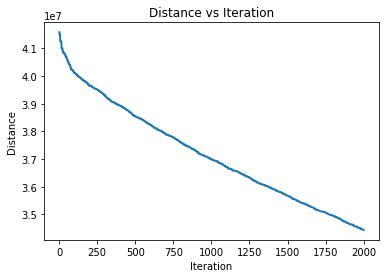

In [15]:
start_time = time.time()
filename = 'tsp-case04.txt'
popSize = 80
eliteSize = 15
mutationProbability = 0.02
iteration_limit = 2000

cityList = genCityList(filename)

population = initialPopulation(popSize, cityList)
distances = [Fitness(p).routeDistance() for p in population]
min_dist = min(distances)
print("Best distance for initial population: " + str(min_dist))

x_axis = np.array(np.arange(1, iteration_limit + 1))
y_axis = []

for i in range(iteration_limit):
    population = oneGeneration(population, eliteSize, mutationProbability)
    distances = [Fitness(p).routeDistance() for p in population]
    min_dist = min(distances)
    y_axis.append(min_dist)
    print("Best distance for population in iteration " + str(i) +
          ": " + str(min_dist))
    
plt.plot(x_axis, y_axis, linewidth=2.0)
plt.xlabel('Iteration')
plt.ylabel('Distance')
plt.title('Distance vs Iteration')

    #SUGGESTION - You could also print/plot the N best routes per
    # iteration, would this give more insight into what's happening?
    #SUGGESTION - The suggested code in this cell stops when a specific
    # number of iterations are reached. Would it help to implement
    # a different stopping criterion (e.g. best fitness no longer
    # improving)?

end_time = time.time()
print("Time taken: {} s".format(end_time-start_time))

# Saving the final solution

Once you have completed the lab, you will have to save the final solution to a CSV file for verification. Note that any cheating (identical CSV files, reporting wrong total distances, or modifying coordinates) will result in zero marks awarded for this lab.

In [16]:
filename = 'mysolution.csv'
distances = [Fitness(p).routeDistance() for p in population]
index = np.argmin(distances)
best_route = population[index]
with open(filename, mode='w') as f:
    writer = csv.writer(f, delimiter=' ', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(len(best_route)):
        writer.writerow([i, best_route[i].x, best_route[i].y])